# MCMC

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

import numpy as np
import jax.numpy as jn
from  matplotlib import pyplot as plt
import jax
from jax import random

from src.utils import l2sq
from src.algorithm import *

plt.rcParams["figure.figsize"]=8,8

(-12.0, 12.0)

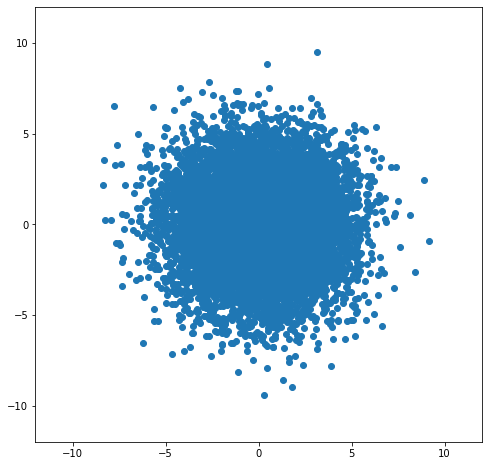

In [2]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

k = 100
M = jnp.zeros(k)
#c = jnp.array([[1,0],[0,10]])
#c_inv = jnp.array([[1, 0], [0,1/10]])

key, *sk = random.split(key, 4)
V = random.normal(sk[0], [k, k])
Q, _ = jnp.linalg.qr(V)
d = jnp.diag(random.uniform(sk[1], (k,))*10)
D= d.at[d < 0].set(0)
C = Q.transpose() @ D @ Q
C_inv = Q.transpose() @ jnp.diag(1/jnp.diag(D)) @ Q

S = random.multivariate_normal(sk[2], M, C, (10000,))
plt.scatter(S[:,0], S[:,1])
plt.xlim(-12,12)
plt.ylim(-12,12)

In [3]:
def plot_mcmc_samples(samples, r, x0, M, C):

    plt.rcParams["figure.figsize"]=16,8

    plt.subplot(1,2,1)
    plt.plot(x0[0], x0[1], 'ro')
    plt.scatter(samples[:,0], samples[:,1])
    plt.xlim(-20,20)
    plt.ylim(-20,20)

    plt.subplot(1,2,2)
    plt.plot(r)

    plt.rcParams["figure.figsize"]=8,8

    M_est = jnp.mean(samples, axis = 0)
    print("Mean error =", jnp.linalg.norm(M - M_est))

    C_est = jnp.cov(samples.transpose())
    print("Covariance error =", jnp.linalg.norm(C - C_est)/jnp.linalg.norm(C))

In [4]:
logPi = lambda x : -1/2 * (x-M) @ C_inv @ (x-M) - jnp.log(jnp.sqrt((2*jnp.pi)**k * jnp.linalg.det(C)))
gradLogPi = jax.grad(logPi)

pi = lambda x : jnp.exp(logPi(x))
logPi = jax.jit(logPi)
gradLogPi = jax.jit(gradLogPi)

In [5]:
#logPi(jnp.array([10,20]))
#gradLogPi(jnp.array([0.,-5.]))

In [6]:
#x = jnp.arange(-20,20)
#y = [pi(jnp.array([0,xi])) for xi in x]
#plt.plot(x,y)
#plt.show
#y2 = [pi(jnp.array([xi,0])) for xi in x]
#plt.plot(x,y2)
#plt.show()
#y3 = [logPi(jnp.array([0,xi])) for xi in x]
#plt.plot(x,y3)

#gradLogPi(jnp.array([0.,-5.]))

In [7]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))
N_samples = 1000
x0 = jnp.array(np.random.randn(k))

### MALA

In [8]:
proposal_params_mala = {"tau" : 0.01}

x_mean_mala, r_mala, samples_mala = mcmc(key, N_samples, proposal_mala, logPi, gradLogPi, x0, proposal_params_mala, 1)

TypeError: unsupported operand type(s) for *: 'int' and 'CompiledFunction'

In [ ]:
plot_mcmc_samples(samples_mala, r_mala, x0, M, C)

### HMC

In [18]:
N_samples=100

In [20]:
proposal_params_hmc = {"dt_list" : jnp.array([0.0001]), "L" : 10, 'logPi' : logPi, 'gradLogPi' : gradLogPi}

x_mean_hmc, r_hmc, samples_hmc = mcmc(key, proposal_hmc, x0, N_samples, proposal_params_hmc, save_samples=1)


  MCMC sample 1, loss = inf, a = 0.0
  MCMC sample 2, loss = inf, a = 0.0
  MCMC sample 3, loss = inf, a = 0.0
  MCMC sample 4, loss = inf, a = 0.0
  MCMC sample 5, loss = inf, a = 0.0
  MCMC sample 6, loss = inf, a = 0.0
  MCMC sample 7, loss = inf, a = 0.0
  MCMC sample 8, loss = inf, a = 0.0
  MCMC sample 9, loss = inf, a = 0.0
  MCMC sample 10, loss = inf, a = 0.0
  MCMC sample 11, loss = inf, a = 0.0
  MCMC sample 12, loss = inf, a = 0.0
  MCMC sample 13, loss = inf, a = 0.0
  MCMC sample 14, loss = inf, a = 0.0
  MCMC sample 15, loss = inf, a = 0.0
  MCMC sample 16, loss = inf, a = 0.0
  MCMC sample 17, loss = inf, a = 0.0
  MCMC sample 18, loss = inf, a = 0.0
  MCMC sample 19, loss = inf, a = 0.0
  MCMC sample 20, loss = inf, a = 0.0
  MCMC sample 21, loss = inf, a = 0.0
  MCMC sample 22, loss = inf, a = 0.0
  MCMC sample 23, loss = inf, a = 0.0
  MCMC sample 24, loss = inf, a = 0.0
  MCMC sample 25, loss = inf, a = 0.0
  MCMC sample 26, loss = inf, a = 0.0
  MCMC sample 27, los

Mean error = 9.358605713318443
Covariance error = 1.0


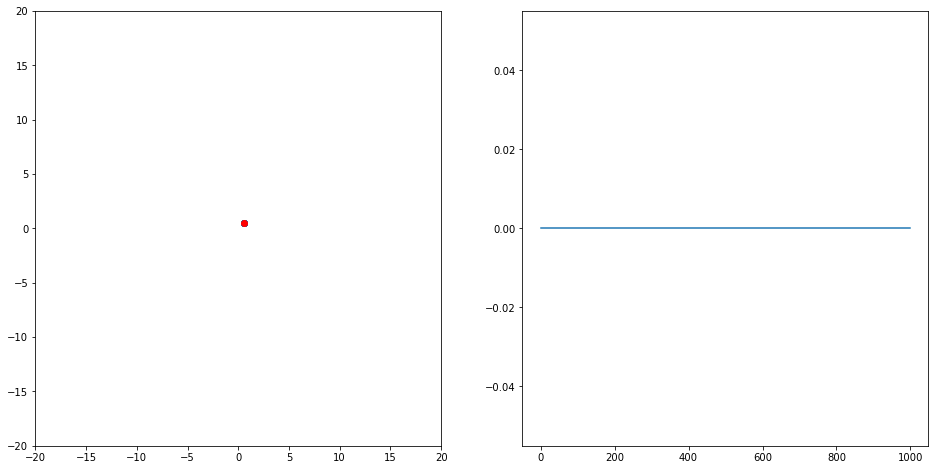

In [17]:
plot_mcmc_samples(samples_hmc, r_hmc, x0, M, C)

In [ ]:
def get_norm_conv(samples, M, C):
    norm_m = []
    norm_c = []
    for i in range(10,N_samples):
        if jnp.mod(i,10) == 0:
            Merr = jnp.linalg.norm(jnp.mean(samples[:i], axis = 0) - M)
            Cerr = jnp.linalg.norm(jnp.cov(samples[:i].transpose()) - C)/jnp.linalg.norm(C)
            norm_m.append(Merr)
            norm_c.append(Cerr)

    norm_m = jnp.array(norm_m)
    norm_c = jnp.array(norm_c)
    return norm_m, norm_c

In [ ]:
norm_m_hmc, norm_c_hmc = get_norm_conv(samples_hmc, M, C)

In [ ]:
norm_m_mala, norm_c_mala = get_norm_conv(samples_mala, M, C)

In [ ]:
xx = []
for i in range(10,N_samples):
    if jnp.mod(i, 10) == 0:
        xx.append(i)
xx = jnp.array(xx)
yy = 1/jnp.sqrt(xx)

In [ ]:
plt.semilogy(norm_m_mala)
plt.semilogy(norm_m_hmc)
plt.semilogy(yy*10)

In [ ]:
plt.semilogy(norm_c_mala)
plt.semilogy(norm_c_hmc)
plt.semilogy(yy*15)